In [89]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import numpy as np
import pickle
import glob, os

In [91]:
param_names = {'pca': 'Principal Components',
 'diffusion': 'Diffusion Time',
 'autoencoder': 'Bottleneck Width'}

In [104]:
results = {}
result_files = glob.glob('../../results/*.pickle')
for file in result_files:
    results[os.path.basename(file).split('.')[0]] = pickle.load(open(file, 'rb'))

In [110]:
hca_pca_mse = results['hca_pca_mse']
hca_diffusion_mse = results['hca_diffusion_mse']
hca_autoencoder_mse = results['hca_autoencoder_mse']

In [111]:
displacement = 0.073
yticks = {'re_loss': (0.04, 0.08),
          'ss_loss': (0.078, 0.086)}
ylim = {'re_loss': (0.03, 0.09),
        'ss_loss': (0.077, 0.087)}
yticks['gt_loss'] = (yticks['ss_loss'][0] - displacement, yticks['ss_loss'][1] - displacement)
ylim['gt_loss'] = (ylim['ss_loss'][0] - displacement, ylim['ss_loss'][1] - displacement)
hca_diffusion_mse['param_min'] = 1

In [112]:
def plot_results(results, displacement=None, yticks=None, ylim=None):
    fig, ax = plt.subplots(3, len(results), sharex = 'col', sharey='row', figsize=(10,10))

    ax[0,0].set_ylabel('Reconstruction Loss')
    ax[1,0].set_ylabel('Self-Supervised Loss')
    ax[2,0].set_ylabel('Ground-Truth Loss')

    if yticks:
        ax[0,0].set_yticks(yticks['re_loss'])
        ax[1,0].set_yticks(yticks['ss_loss'])
        ax[2,0].set_yticks(yticks['gt_loss'])
    if ylim:
        ax[0,0].set_ylim(ylim['re_loss'])
        ax[1,0].set_ylim(ylim['ss_loss'])
        ax[2,0].set_ylim(ylim['gt_loss'])
    for i, result in enumerate(results):
        param_range = result['param_range']
        if 'param_min' not in result:
            param_min = 0
        else:
            param_min = result['param_min']
        if 'param_max' not in result:
            param_max = len(param_range)
        else:
            param_max = result['param_max']
            
        ax[0,i].plot(param_range[param_min:param_max], result['re_loss'][param_min:param_max])
        ax[1,i].plot(param_range[param_min:param_max], result['ss_loss'][param_min:param_max])
        ax[2,i].plot(param_range[param_min:param_max], result['gt_loss'][param_min:param_max], '--')
        
        ax[0,i].set_title(result['method'])
        ax[2,i].set_xlabel(param_names[result['method']])

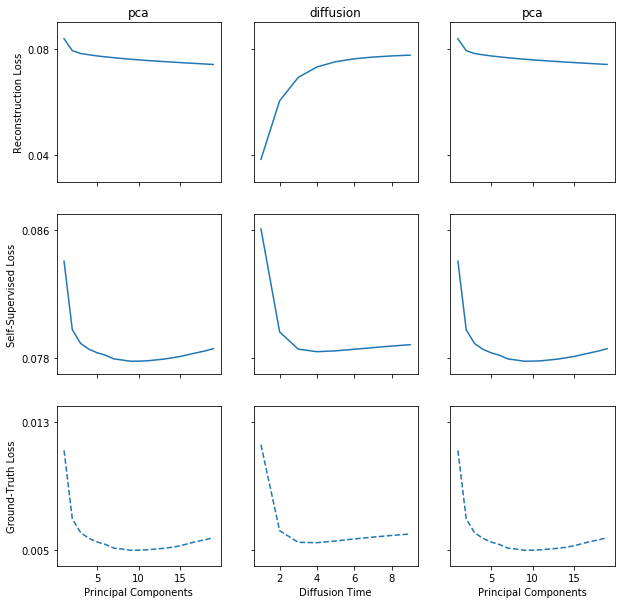

In [113]:
plot_results([hca_pca_mse, hca_diffusion_mse, hca_pca_mse],
            yticks=yticks, ylim=ylim)
plt.savefig('figures/hca_mse.svg')

# Simulated

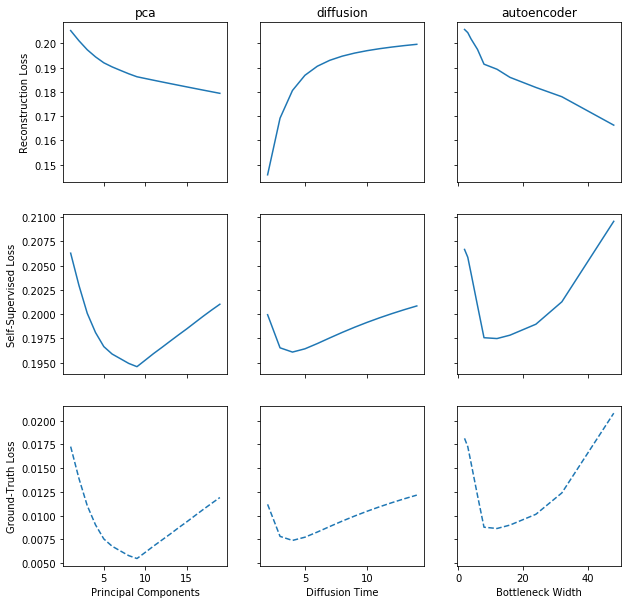

In [109]:
sim_pca_mse = results['sim_pca_mse']
sim_diffusion_mse = results['sim_diffusion_mse']
sim_autoencoder_mse = results['sim_autoencoder_mse']

sim_diffusion_mse['param_min'] = 2
sim_autoencoder_mse['param_max'] = -3

plot_results([sim_pca_mse, sim_diffusion_mse, sim_autoencoder_mse])
plt.savefig('figures/sim_mse.svg')

# Poisson Loss

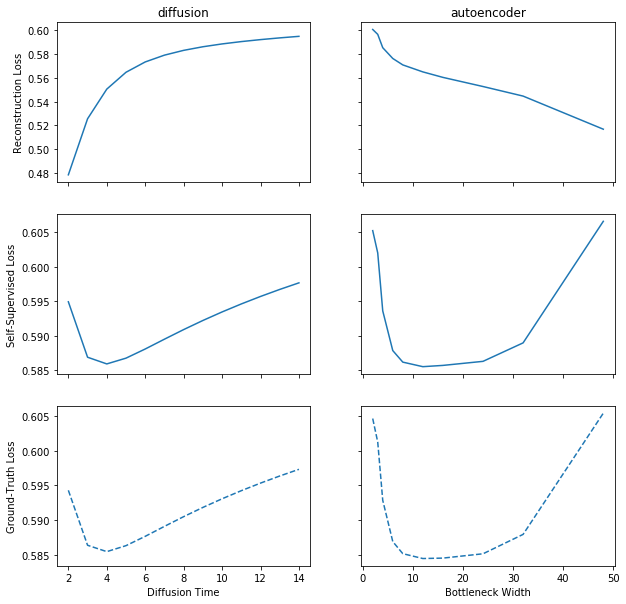

In [107]:
sim_diffusion_p = results['sim_diffusion_poisson']
sim_autoencoder_p = results['sim_autoencoder_poisson']

sim_diffusion_p['param_min'] = 2
sim_autoencoder_p['param_max'] = -3

plot_results([sim_diffusion_p, sim_autoencoder_p])
plt.savefig('figures/sim_poisson.svg')